# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [69]:
from glob import glob
paths = sorted(glob('data/*'))
paths

['data\\movies_test.csv', 'data\\movies_train.csv', 'data\\submission.csv']

In [70]:
train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

train.shape, test.shape

((600, 12), (243, 11))

In [71]:
# train과 test의 데이터를 출력해봅니다
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [73]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
round(train.describe(), 2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.00,270.00,600.00,600.00,600.00,600.00
mean,100.86,1050442.89,0.88,151.12,3.71,708181.75
std,18.10,1791408.30,1.18,165.65,2.45,1828005.85
min,45.00,1.00,0.00,0.00,0.00,1.00
25%,89.00,20380.00,0.00,17.00,2.00,1297.25
50%,100.00,478423.62,0.00,82.50,3.00,12591.00
75%,114.00,1286568.62,2.00,264.00,4.00,479886.75
max,180.00,17615314.00,5.00,869.00,25.00,14262766.00


In [74]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [75]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
round(test.describe(), 2)

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,243.00,107.00,243.00,243.00,243.00
mean,109.80,891669.52,0.85,159.32,3.48
std,124.02,1217341.45,1.20,162.98,2.11
min,40.00,34.00,0.00,0.00,0.00
25%,91.00,62502.00,0.00,18.00,2.00
50%,104.00,493120.00,0.00,105.00,3.00
75%,114.50,1080849.58,1.00,282.00,4.00
max,2015.00,6173099.50,6.00,776.00,16.00


#### 결측치 확인

In [76]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [77]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

Text(0.5, 1.0, 'Test - Missing')

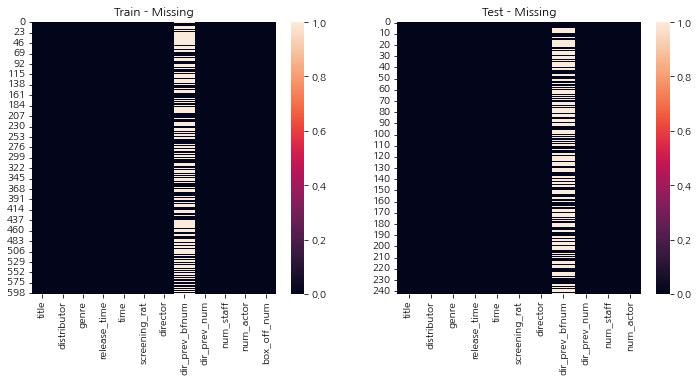

In [78]:
# 결측치를 시각화해봅니다
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

sns.heatmap(train.isna(), ax=axes[0]).set_title('Train - Missing')
sns.heatmap(test.isna(), ax=axes[1]).set_title('Test - Missing')

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [79]:
# \(|주|\) 는 데이터에서 제거해줍니다
train['distributor'] = train['distributor'].str.replace('\(|주|\)', '')

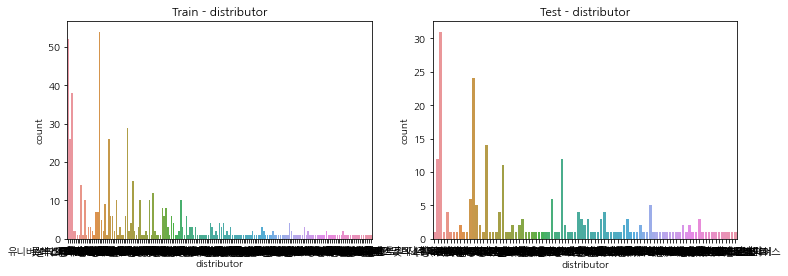

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
sns.countplot(train['distributor'], ax=axes[0]).set_title('Train - distributor')
sns.countplot(test['distributor'], ax=axes[1]).set_title('Test - distributor')
plt.show()

In [81]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

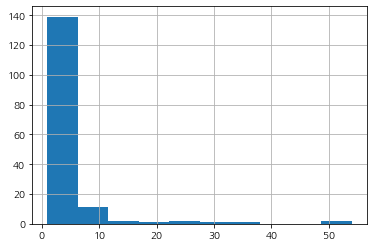

In [82]:
_ = train["distributor"].value_counts().hist()

In [83]:
pd.DataFrame(train['distributor'].value_counts()).loc['NEW'] > 10

distributor    True
Name: NEW, dtype: bool

In [84]:
train.loc[:, 'distributor']

0       롯데엔터테인먼트
1            쇼박스
2            쇼박스
3            NEW
4      쇼박스미디어플렉스
         ...    
595          NEW
596          쇼박스
597       마운틴픽쳐스
598     CJ엔터테인먼트
599     CJ엔터테인먼트
Name: distributor, Length: 600, dtype: object

In [85]:
set(test["distributor"]) - set(train["distributor"])

{'CinemaSAM',
 '갑종필름',
 '굿픽처스',
 '나이너스엔터테인먼트주',
 '노근리프로덕션',
 '늘푸른시네마',
 '레몬트리',
 '롯데쇼핑주롯데엔터테인먼트',
 '리아코어콘텐츠',
 '리얼라이즈픽쳐스',
 '메가박스주플러스엠',
 '메가박스중앙주플러스엠',
 '명필름',
 '모쿠슈라',
 '미디어로그',
 '미로비젼',
 '비에이치제이시네마',
 '쇼박스주미디어플렉스',
 '씨너스엔터테인먼트주',
 '씨네그루주키다리이엔티',
 '애니메이션배급',
 '오픈유컬쳐',
 '와우픽쳐스',
 '유나이티드픽처스',
 '유영화사화수분',
 '이십세기폭스코리아주',
 '주NEW',
 '주노버스엔터테인먼트',
 '주다세포클럽',
 '주두타연',
 '주드림웨스트픽쳐스',
 '주디씨드',
 '주루믹스미디어',
 '주루스이소니도스',
 '주마운틴픽쳐스',
 '주마인스엔터테인먼트',
 '주미디어데이',
 '주쇼박스',
 '주스톰픽쳐스코리아',
 '주씨타마운틴픽쳐스',
 '주액티버스엔터테인먼트',
 '주에이원엔터테인먼트',
 '주엣나인필름',
 '주영화사빅',
 '주영화사조제',
 '주영화제작전원사',
 '주예지림엔터테인먼트',
 '주컨텐츠온미디어',
 '주케이알씨지',
 '주키노아이',
 '주팝엔터테인먼트',
 '청년필름',
 '크리에이티브컴즈주',
 '타임스토리',
 '프리비젼',
 '필마픽쳐스',
 '핑크로봇필름'}

In [86]:
 set(train["distributor"].value_counts()[:7].index) - set(test['distributor'])

{'쇼박스'}

In [61]:
'쇼박스' in test['distributor']

False

In [62]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
def distributor_band(x):
    try:
        if train['distributor'].value_counts().loc[x] > 15:
            return '중대형'
        
    except:
        return '소형'
    
    else:
        return '소형'


In [63]:
train["distributor"].apply(distributor_band).value_counts()

소형     357
중대형    243
Name: distributor, dtype: int64

In [64]:
test["distributor"].apply(distributor_band).value_counts()

소형     165
중대형     78
Name: distributor, dtype: int64

In [65]:
# 위 함수를 train과 test에 모두 적용합니다
train['distributor_category'] = train["distributor"].apply(distributor_band)
test['distributor_category'] = test["distributor"].apply(distributor_band)

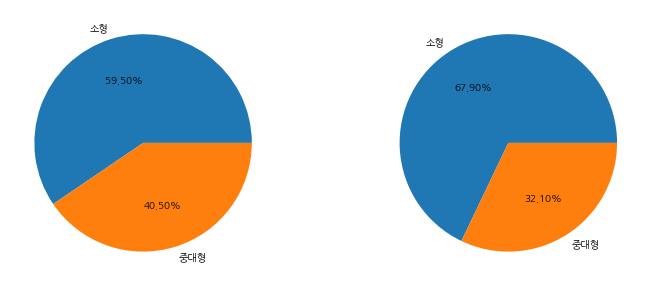

In [66]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor_category"].value_counts().values, labels=train["distributor_category"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor_category"].value_counts().values, labels=test["distributor_category"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [109]:
train.groupby("genre")["box_off_num"].mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [21]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다

In [22]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [23]:
# 인코딩 전의 장르 컬럼은 버려줍니다

### release_time: 개봉일

In [24]:
# 개봉일의 데이터타입은 datetime으로 변경합니다

In [25]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다

In [26]:
# 기존 데이터는 삭제합니다

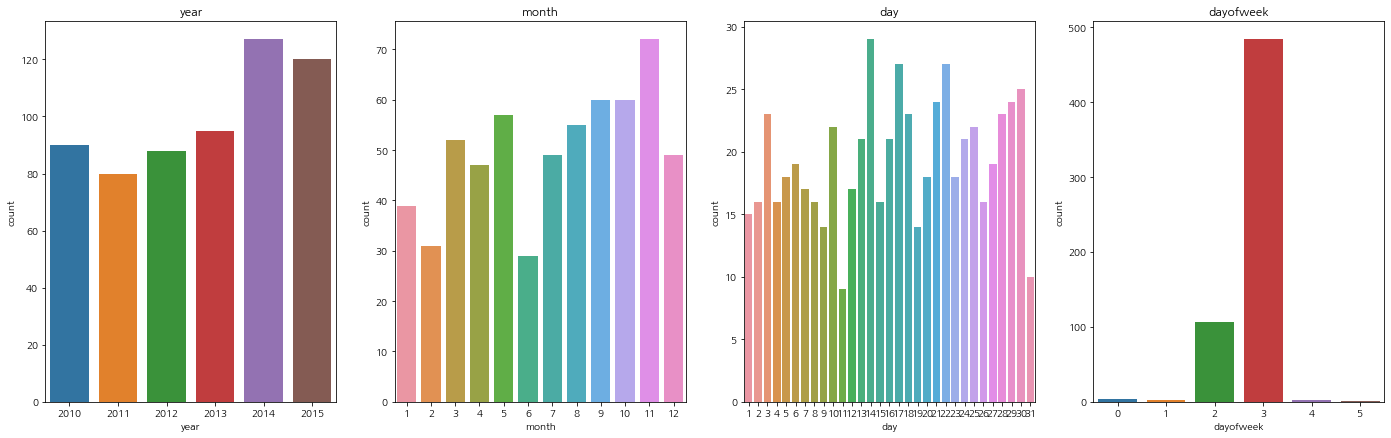

In [27]:
# 요일별로 시각화 해봅니다

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [28]:
# 제목과 감독 데이터는 버려줍니다

In [29]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [30]:
# 범주형 데이터들을 인코딩해줍니다

In [31]:
# 피처와 라벨을 구합니다

['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

### Log Scale

In [32]:
# 등장 배우의 수에 로그 스케일을 적용합니다

In [33]:
X_train, X_val, y_train, y_val = train_test_split(train[features], train[label], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [34]:
test.shape

(243, 16)

### Random Forest

rmse: 1377636.6138653848


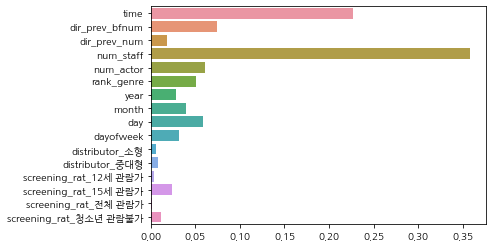

### XGBoost

rmse: 1444161.2032999645


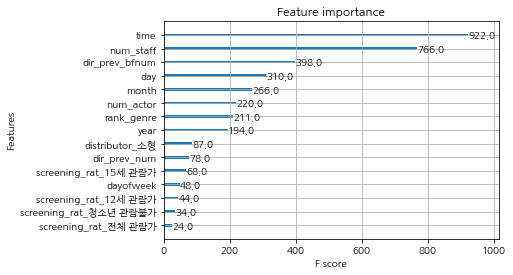

### LightGBM

rmse: 1444161.2032999645


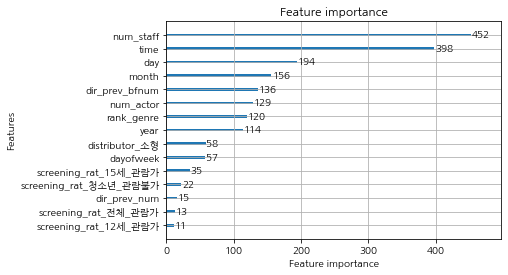